# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [03:03, 991KB/s]                               
SVHN Testing Set: 64.3MB [01:06, 970KB/s]                             


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

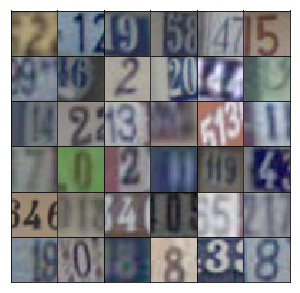

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [22]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        
        # Reshape
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # Now is 4*4*512
        
        # Conv layer
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # Now is 8*8*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # Now is 16*16*128
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, 3, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [24]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # 2nd layer
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 3nd layer
        x3 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Flatten 
        x4 = tf.reshape(x3, (-1, 4 * 4 * 256))
        
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [31]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 3.1794... Generator Loss: 0.0907
Epoch 1/25... Discriminator Loss: 1.6063... Generator Loss: 0.4593
Epoch 1/25... Discriminator Loss: 0.8400... Generator Loss: 0.9993
Epoch 1/25... Discriminator Loss: 0.5791... Generator Loss: 1.5526
Epoch 1/25... Discriminator Loss: 0.4882... Generator Loss: 2.0920
Epoch 1/25... Discriminator Loss: 0.3559... Generator Loss: 1.9270
Epoch 1/25... Discriminator Loss: 0.3020... Generator Loss: 2.5163
Epoch 1/25... Discriminator Loss: 0.3311... Generator Loss: 2.1607
Epoch 1/25... Discriminator Loss: 0.3691... Generator Loss: 1.8733
Epoch 1/25... Discriminator Loss: 0.3873... Generator Loss: 1.8834


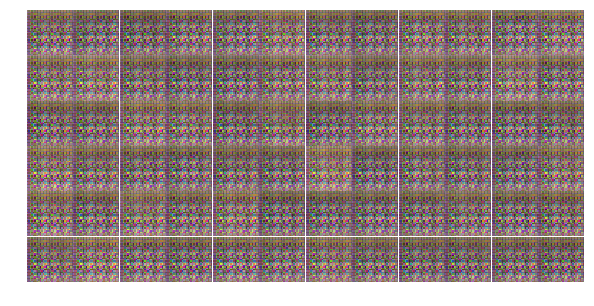

Epoch 1/25... Discriminator Loss: 0.4213... Generator Loss: 1.6161
Epoch 1/25... Discriminator Loss: 0.6038... Generator Loss: 1.6968
Epoch 1/25... Discriminator Loss: 0.7636... Generator Loss: 1.3026
Epoch 1/25... Discriminator Loss: 0.6129... Generator Loss: 1.6380
Epoch 1/25... Discriminator Loss: 0.6379... Generator Loss: 1.5973
Epoch 1/25... Discriminator Loss: 0.5812... Generator Loss: 1.6392
Epoch 1/25... Discriminator Loss: 0.4535... Generator Loss: 1.6864
Epoch 1/25... Discriminator Loss: 0.6195... Generator Loss: 1.4598
Epoch 1/25... Discriminator Loss: 1.1123... Generator Loss: 0.9802
Epoch 1/25... Discriminator Loss: 1.1620... Generator Loss: 0.9053


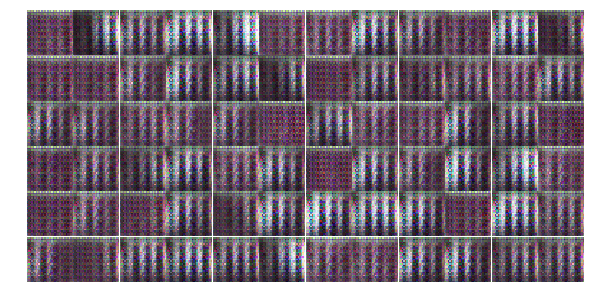

Epoch 1/25... Discriminator Loss: 1.2794... Generator Loss: 0.8331
Epoch 1/25... Discriminator Loss: 1.3603... Generator Loss: 0.8850
Epoch 1/25... Discriminator Loss: 1.1915... Generator Loss: 0.9931
Epoch 1/25... Discriminator Loss: 1.1233... Generator Loss: 1.0169
Epoch 1/25... Discriminator Loss: 1.1502... Generator Loss: 0.9205
Epoch 1/25... Discriminator Loss: 1.1049... Generator Loss: 0.8739
Epoch 1/25... Discriminator Loss: 0.9931... Generator Loss: 0.9750
Epoch 1/25... Discriminator Loss: 1.0513... Generator Loss: 0.9299
Epoch 1/25... Discriminator Loss: 1.0454... Generator Loss: 1.0372
Epoch 1/25... Discriminator Loss: 1.2318... Generator Loss: 0.8170


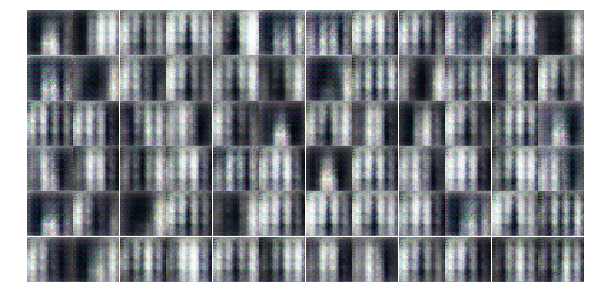

Epoch 1/25... Discriminator Loss: 1.2225... Generator Loss: 0.8054
Epoch 1/25... Discriminator Loss: 0.8197... Generator Loss: 1.1053
Epoch 1/25... Discriminator Loss: 1.0880... Generator Loss: 0.9744
Epoch 1/25... Discriminator Loss: 1.0298... Generator Loss: 1.2258
Epoch 1/25... Discriminator Loss: 1.0576... Generator Loss: 0.9782
Epoch 1/25... Discriminator Loss: 0.9962... Generator Loss: 1.1286
Epoch 1/25... Discriminator Loss: 0.9485... Generator Loss: 1.1222
Epoch 1/25... Discriminator Loss: 1.0205... Generator Loss: 1.1101
Epoch 1/25... Discriminator Loss: 1.0041... Generator Loss: 0.9778
Epoch 1/25... Discriminator Loss: 1.1009... Generator Loss: 1.0305


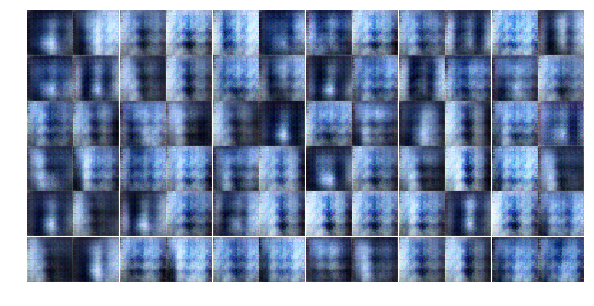

Epoch 1/25... Discriminator Loss: 1.3750... Generator Loss: 0.6855
Epoch 1/25... Discriminator Loss: 1.2801... Generator Loss: 0.9475
Epoch 1/25... Discriminator Loss: 1.0614... Generator Loss: 0.8970
Epoch 1/25... Discriminator Loss: 1.1366... Generator Loss: 1.3233
Epoch 1/25... Discriminator Loss: 0.9594... Generator Loss: 1.0053
Epoch 1/25... Discriminator Loss: 0.8825... Generator Loss: 0.9133
Epoch 1/25... Discriminator Loss: 1.2025... Generator Loss: 1.0122
Epoch 1/25... Discriminator Loss: 1.1707... Generator Loss: 0.8005
Epoch 1/25... Discriminator Loss: 1.2105... Generator Loss: 0.8835
Epoch 1/25... Discriminator Loss: 0.9582... Generator Loss: 0.9067


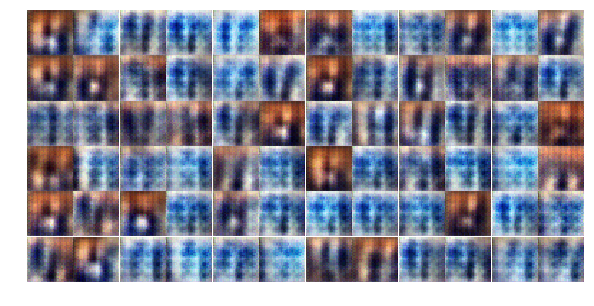

Epoch 1/25... Discriminator Loss: 1.1332... Generator Loss: 0.9070
Epoch 1/25... Discriminator Loss: 1.2779... Generator Loss: 0.8663
Epoch 1/25... Discriminator Loss: 1.2075... Generator Loss: 0.8440
Epoch 1/25... Discriminator Loss: 1.3770... Generator Loss: 0.6644
Epoch 1/25... Discriminator Loss: 1.3757... Generator Loss: 0.8321
Epoch 1/25... Discriminator Loss: 1.1356... Generator Loss: 0.9656
Epoch 1/25... Discriminator Loss: 1.1098... Generator Loss: 1.0207
Epoch 2/25... Discriminator Loss: 1.1414... Generator Loss: 0.8768
Epoch 2/25... Discriminator Loss: 0.8846... Generator Loss: 1.1777
Epoch 2/25... Discriminator Loss: 1.4789... Generator Loss: 0.5508


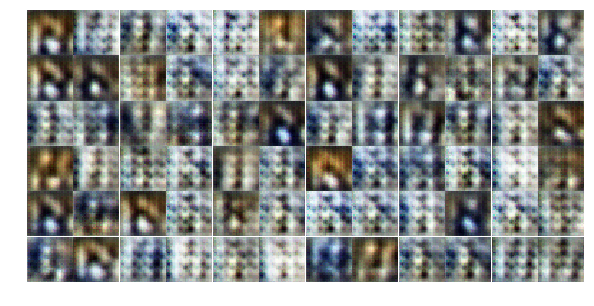

Epoch 2/25... Discriminator Loss: 1.1094... Generator Loss: 1.0342
Epoch 2/25... Discriminator Loss: 1.1630... Generator Loss: 0.8282
Epoch 2/25... Discriminator Loss: 1.1360... Generator Loss: 0.8412
Epoch 2/25... Discriminator Loss: 0.8319... Generator Loss: 1.2804
Epoch 2/25... Discriminator Loss: 0.7444... Generator Loss: 1.4600
Epoch 2/25... Discriminator Loss: 0.7787... Generator Loss: 1.4379
Epoch 2/25... Discriminator Loss: 0.9746... Generator Loss: 1.0287
Epoch 2/25... Discriminator Loss: 0.8664... Generator Loss: 1.3400
Epoch 2/25... Discriminator Loss: 1.1249... Generator Loss: 0.8346
Epoch 2/25... Discriminator Loss: 0.9635... Generator Loss: 0.9497


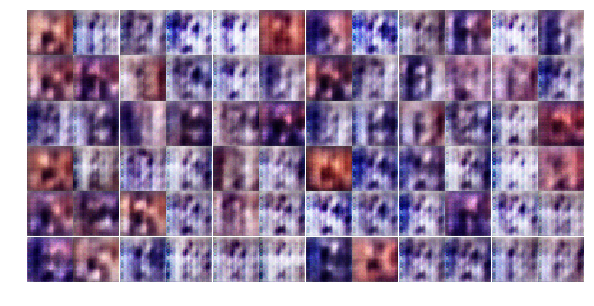

Epoch 2/25... Discriminator Loss: 0.9451... Generator Loss: 0.9307
Epoch 2/25... Discriminator Loss: 1.0022... Generator Loss: 1.3668
Epoch 2/25... Discriminator Loss: 0.8299... Generator Loss: 1.3788
Epoch 2/25... Discriminator Loss: 0.8874... Generator Loss: 1.3843
Epoch 2/25... Discriminator Loss: 0.8603... Generator Loss: 1.0920
Epoch 2/25... Discriminator Loss: 0.8146... Generator Loss: 1.2235
Epoch 2/25... Discriminator Loss: 0.9120... Generator Loss: 1.1581
Epoch 2/25... Discriminator Loss: 1.1202... Generator Loss: 0.6119
Epoch 2/25... Discriminator Loss: 1.0096... Generator Loss: 1.2518
Epoch 2/25... Discriminator Loss: 0.7377... Generator Loss: 1.6934


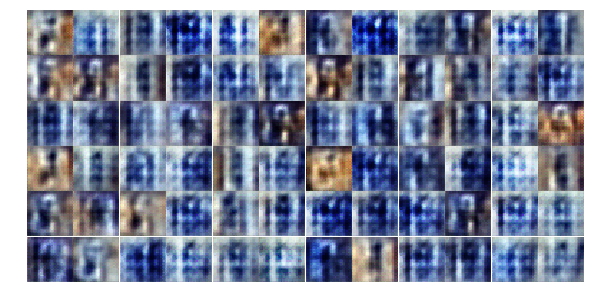

Epoch 2/25... Discriminator Loss: 0.8091... Generator Loss: 1.1237
Epoch 2/25... Discriminator Loss: 0.9231... Generator Loss: 1.8853
Epoch 2/25... Discriminator Loss: 0.7373... Generator Loss: 1.5952
Epoch 2/25... Discriminator Loss: 1.1669... Generator Loss: 1.1849
Epoch 2/25... Discriminator Loss: 1.1274... Generator Loss: 1.0348
Epoch 2/25... Discriminator Loss: 1.2092... Generator Loss: 0.8092
Epoch 2/25... Discriminator Loss: 1.4568... Generator Loss: 0.4616
Epoch 2/25... Discriminator Loss: 1.1776... Generator Loss: 0.9335
Epoch 2/25... Discriminator Loss: 1.4952... Generator Loss: 0.6059
Epoch 2/25... Discriminator Loss: 1.1634... Generator Loss: 0.8549


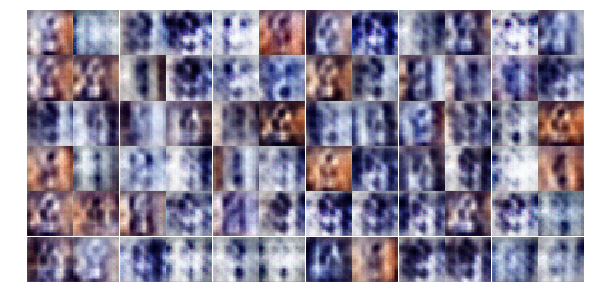

Epoch 2/25... Discriminator Loss: 0.9455... Generator Loss: 1.2963
Epoch 2/25... Discriminator Loss: 0.8311... Generator Loss: 1.3100
Epoch 2/25... Discriminator Loss: 1.3590... Generator Loss: 0.7216
Epoch 2/25... Discriminator Loss: 1.2176... Generator Loss: 0.7668
Epoch 2/25... Discriminator Loss: 0.9876... Generator Loss: 1.1020
Epoch 2/25... Discriminator Loss: 1.0370... Generator Loss: 0.9182
Epoch 2/25... Discriminator Loss: 0.9901... Generator Loss: 0.9930
Epoch 2/25... Discriminator Loss: 1.0057... Generator Loss: 1.0605
Epoch 2/25... Discriminator Loss: 1.0459... Generator Loss: 0.9595
Epoch 2/25... Discriminator Loss: 1.0663... Generator Loss: 0.8511


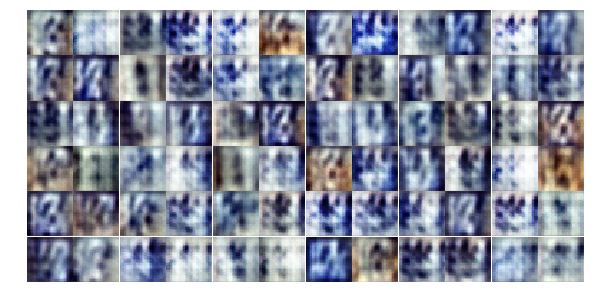

Epoch 2/25... Discriminator Loss: 0.8861... Generator Loss: 1.3884
Epoch 2/25... Discriminator Loss: 1.4040... Generator Loss: 0.8326
Epoch 2/25... Discriminator Loss: 0.7767... Generator Loss: 1.4888
Epoch 2/25... Discriminator Loss: 0.9162... Generator Loss: 1.0660
Epoch 2/25... Discriminator Loss: 1.1163... Generator Loss: 0.9839
Epoch 2/25... Discriminator Loss: 1.4702... Generator Loss: 0.5772
Epoch 2/25... Discriminator Loss: 1.1566... Generator Loss: 1.1487
Epoch 2/25... Discriminator Loss: 1.0048... Generator Loss: 1.0851
Epoch 2/25... Discriminator Loss: 1.1463... Generator Loss: 0.8322
Epoch 2/25... Discriminator Loss: 0.9346... Generator Loss: 1.1504


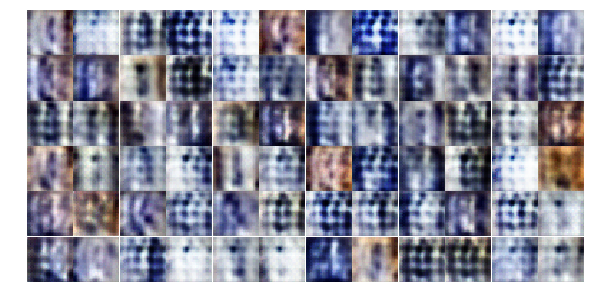

Epoch 2/25... Discriminator Loss: 1.4124... Generator Loss: 0.8041
Epoch 2/25... Discriminator Loss: 1.1610... Generator Loss: 0.9735
Epoch 2/25... Discriminator Loss: 1.2839... Generator Loss: 0.7569
Epoch 2/25... Discriminator Loss: 1.1356... Generator Loss: 0.7934
Epoch 3/25... Discriminator Loss: 1.0712... Generator Loss: 1.2149
Epoch 3/25... Discriminator Loss: 1.0837... Generator Loss: 0.8878
Epoch 3/25... Discriminator Loss: 1.2042... Generator Loss: 0.8670
Epoch 3/25... Discriminator Loss: 0.9599... Generator Loss: 0.9746
Epoch 3/25... Discriminator Loss: 1.1381... Generator Loss: 0.9024
Epoch 3/25... Discriminator Loss: 1.1794... Generator Loss: 0.9035


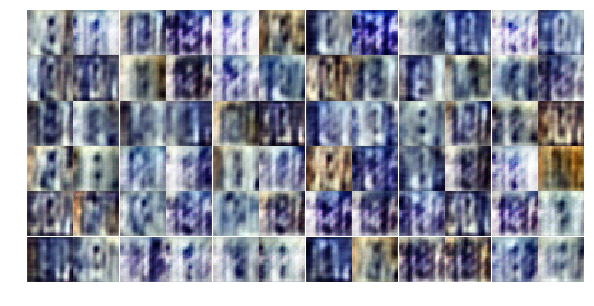

Epoch 3/25... Discriminator Loss: 1.0226... Generator Loss: 1.1255
Epoch 3/25... Discriminator Loss: 1.3693... Generator Loss: 0.6603
Epoch 3/25... Discriminator Loss: 0.9737... Generator Loss: 0.9143
Epoch 3/25... Discriminator Loss: 1.2758... Generator Loss: 0.7295
Epoch 3/25... Discriminator Loss: 1.3678... Generator Loss: 0.5794
Epoch 3/25... Discriminator Loss: 1.2964... Generator Loss: 0.6473
Epoch 3/25... Discriminator Loss: 1.3383... Generator Loss: 0.7901
Epoch 3/25... Discriminator Loss: 1.1840... Generator Loss: 0.8190
Epoch 3/25... Discriminator Loss: 1.4997... Generator Loss: 0.5053
Epoch 3/25... Discriminator Loss: 1.2973... Generator Loss: 0.7526


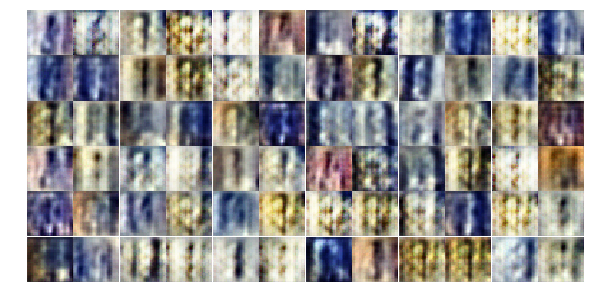

Epoch 3/25... Discriminator Loss: 1.2914... Generator Loss: 0.8766
Epoch 3/25... Discriminator Loss: 1.2049... Generator Loss: 0.8610
Epoch 3/25... Discriminator Loss: 1.1596... Generator Loss: 0.7891
Epoch 3/25... Discriminator Loss: 1.1434... Generator Loss: 0.9772
Epoch 3/25... Discriminator Loss: 1.1798... Generator Loss: 0.8197
Epoch 3/25... Discriminator Loss: 1.1214... Generator Loss: 0.9216
Epoch 3/25... Discriminator Loss: 1.0340... Generator Loss: 0.8266
Epoch 3/25... Discriminator Loss: 1.2502... Generator Loss: 0.7084
Epoch 3/25... Discriminator Loss: 1.2035... Generator Loss: 1.1215
Epoch 3/25... Discriminator Loss: 0.9783... Generator Loss: 1.0024


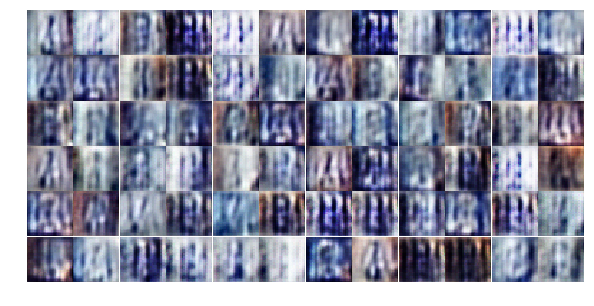

Epoch 3/25... Discriminator Loss: 1.3829... Generator Loss: 0.7143
Epoch 3/25... Discriminator Loss: 1.1699... Generator Loss: 0.9334
Epoch 3/25... Discriminator Loss: 1.1372... Generator Loss: 1.0410
Epoch 3/25... Discriminator Loss: 1.7369... Generator Loss: 0.4467
Epoch 3/25... Discriminator Loss: 1.3965... Generator Loss: 0.5978
Epoch 3/25... Discriminator Loss: 1.1549... Generator Loss: 1.0943
Epoch 3/25... Discriminator Loss: 1.1103... Generator Loss: 1.1384
Epoch 3/25... Discriminator Loss: 1.1186... Generator Loss: 1.0937
Epoch 3/25... Discriminator Loss: 0.9948... Generator Loss: 1.1750
Epoch 3/25... Discriminator Loss: 0.8652... Generator Loss: 0.9919


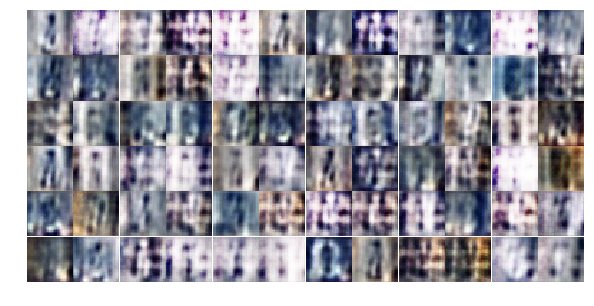

Epoch 3/25... Discriminator Loss: 0.7662... Generator Loss: 1.6051
Epoch 3/25... Discriminator Loss: 0.9029... Generator Loss: 1.1041
Epoch 3/25... Discriminator Loss: 0.8655... Generator Loss: 1.1178
Epoch 3/25... Discriminator Loss: 1.1917... Generator Loss: 0.8150
Epoch 3/25... Discriminator Loss: 1.1020... Generator Loss: 0.9058
Epoch 3/25... Discriminator Loss: 1.1085... Generator Loss: 0.8735
Epoch 3/25... Discriminator Loss: 1.2542... Generator Loss: 0.8338
Epoch 3/25... Discriminator Loss: 1.1857... Generator Loss: 0.9849
Epoch 3/25... Discriminator Loss: 1.1961... Generator Loss: 1.6001
Epoch 3/25... Discriminator Loss: 1.3500... Generator Loss: 0.6409


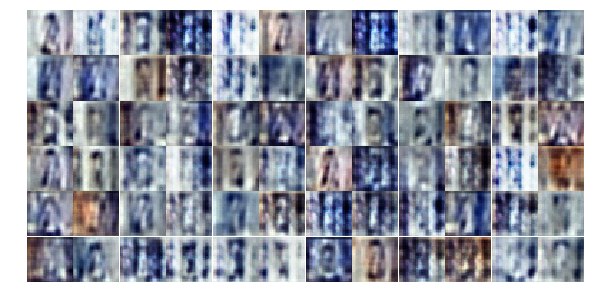

Epoch 3/25... Discriminator Loss: 1.5612... Generator Loss: 0.6176
Epoch 3/25... Discriminator Loss: 1.2395... Generator Loss: 1.0515
Epoch 3/25... Discriminator Loss: 1.2316... Generator Loss: 0.7208
Epoch 3/25... Discriminator Loss: 1.2978... Generator Loss: 0.8504
Epoch 3/25... Discriminator Loss: 1.1787... Generator Loss: 0.8881
Epoch 3/25... Discriminator Loss: 1.0937... Generator Loss: 0.9761
Epoch 3/25... Discriminator Loss: 0.9814... Generator Loss: 0.9473
Epoch 3/25... Discriminator Loss: 1.1155... Generator Loss: 0.9203
Epoch 3/25... Discriminator Loss: 1.2209... Generator Loss: 0.8307
Epoch 3/25... Discriminator Loss: 1.2291... Generator Loss: 0.9335


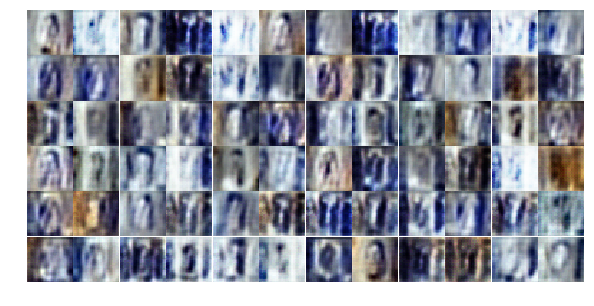

Epoch 3/25... Discriminator Loss: 1.3698... Generator Loss: 0.7430
Epoch 4/25... Discriminator Loss: 1.2516... Generator Loss: 0.7805
Epoch 4/25... Discriminator Loss: 1.1415... Generator Loss: 0.9637
Epoch 4/25... Discriminator Loss: 1.2854... Generator Loss: 0.7136
Epoch 4/25... Discriminator Loss: 1.1986... Generator Loss: 1.0189
Epoch 4/25... Discriminator Loss: 1.1476... Generator Loss: 0.8807
Epoch 4/25... Discriminator Loss: 1.3192... Generator Loss: 0.7694
Epoch 4/25... Discriminator Loss: 1.1586... Generator Loss: 1.0372
Epoch 4/25... Discriminator Loss: 1.1616... Generator Loss: 0.6211
Epoch 4/25... Discriminator Loss: 1.0717... Generator Loss: 0.9824


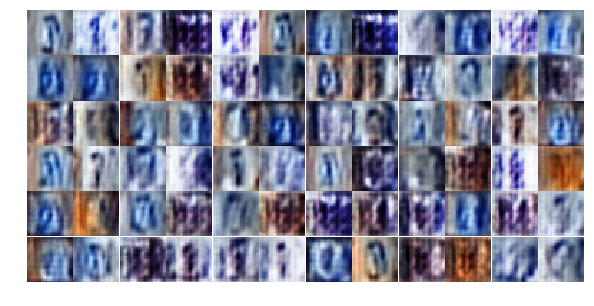

Epoch 4/25... Discriminator Loss: 0.9863... Generator Loss: 1.0310
Epoch 4/25... Discriminator Loss: 1.1927... Generator Loss: 0.7283
Epoch 4/25... Discriminator Loss: 1.2197... Generator Loss: 0.8357
Epoch 4/25... Discriminator Loss: 1.2356... Generator Loss: 0.7925
Epoch 4/25... Discriminator Loss: 1.3643... Generator Loss: 0.7459
Epoch 4/25... Discriminator Loss: 1.2351... Generator Loss: 0.7613
Epoch 4/25... Discriminator Loss: 1.0724... Generator Loss: 1.0459
Epoch 4/25... Discriminator Loss: 1.0960... Generator Loss: 1.0105
Epoch 4/25... Discriminator Loss: 1.5393... Generator Loss: 0.5270
Epoch 4/25... Discriminator Loss: 1.1472... Generator Loss: 1.0193


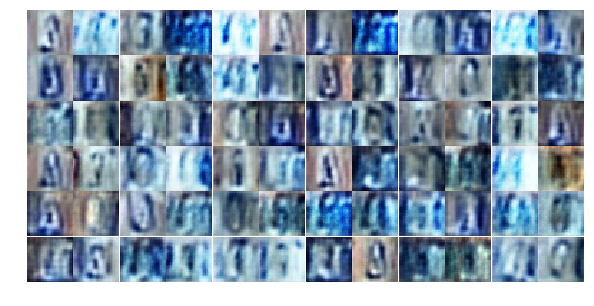

Epoch 4/25... Discriminator Loss: 1.1915... Generator Loss: 1.2561
Epoch 4/25... Discriminator Loss: 1.0661... Generator Loss: 0.7915
Epoch 4/25... Discriminator Loss: 1.3154... Generator Loss: 0.7322
Epoch 4/25... Discriminator Loss: 1.1829... Generator Loss: 0.9262
Epoch 4/25... Discriminator Loss: 0.9456... Generator Loss: 1.0113
Epoch 4/25... Discriminator Loss: 1.0526... Generator Loss: 1.1304
Epoch 4/25... Discriminator Loss: 1.2838... Generator Loss: 0.7770
Epoch 4/25... Discriminator Loss: 1.1614... Generator Loss: 0.8749
Epoch 4/25... Discriminator Loss: 1.1254... Generator Loss: 0.9648
Epoch 4/25... Discriminator Loss: 0.9596... Generator Loss: 1.0826


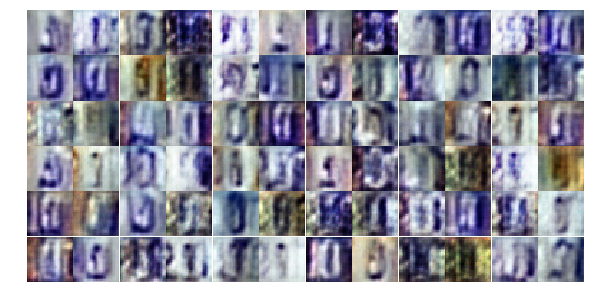

Epoch 4/25... Discriminator Loss: 1.2850... Generator Loss: 0.8333
Epoch 4/25... Discriminator Loss: 1.2537... Generator Loss: 0.6738
Epoch 4/25... Discriminator Loss: 1.0724... Generator Loss: 0.9354
Epoch 4/25... Discriminator Loss: 1.0605... Generator Loss: 1.0096
Epoch 4/25... Discriminator Loss: 1.1970... Generator Loss: 0.9372
Epoch 4/25... Discriminator Loss: 0.9868... Generator Loss: 1.0509
Epoch 4/25... Discriminator Loss: 1.2850... Generator Loss: 0.6602
Epoch 4/25... Discriminator Loss: 1.4150... Generator Loss: 0.6337
Epoch 4/25... Discriminator Loss: 1.2618... Generator Loss: 0.9315
Epoch 4/25... Discriminator Loss: 0.9171... Generator Loss: 0.9808


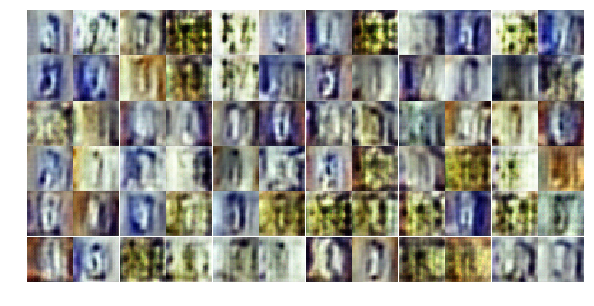

Epoch 4/25... Discriminator Loss: 1.9019... Generator Loss: 0.4666
Epoch 4/25... Discriminator Loss: 1.1650... Generator Loss: 1.0257
Epoch 4/25... Discriminator Loss: 1.6455... Generator Loss: 0.5623
Epoch 4/25... Discriminator Loss: 1.1617... Generator Loss: 0.8558
Epoch 4/25... Discriminator Loss: 1.2387... Generator Loss: 0.8547
Epoch 4/25... Discriminator Loss: 1.3453... Generator Loss: 0.8061
Epoch 4/25... Discriminator Loss: 1.2527... Generator Loss: 0.7642
Epoch 4/25... Discriminator Loss: 1.2730... Generator Loss: 0.7635
Epoch 4/25... Discriminator Loss: 1.1948... Generator Loss: 0.8312
Epoch 4/25... Discriminator Loss: 1.4310... Generator Loss: 0.7590


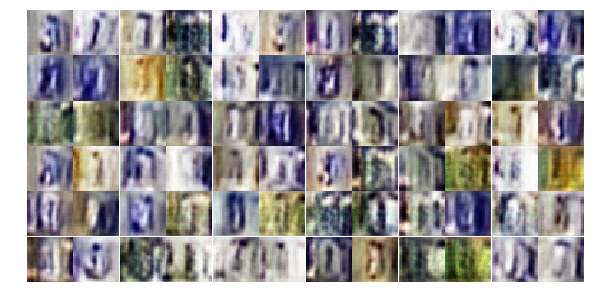

Epoch 4/25... Discriminator Loss: 1.0675... Generator Loss: 0.8115
Epoch 4/25... Discriminator Loss: 1.2878... Generator Loss: 0.8641
Epoch 4/25... Discriminator Loss: 1.1486... Generator Loss: 0.9177
Epoch 4/25... Discriminator Loss: 1.1175... Generator Loss: 1.0420
Epoch 4/25... Discriminator Loss: 1.2361... Generator Loss: 0.8272
Epoch 4/25... Discriminator Loss: 1.1931... Generator Loss: 1.0016
Epoch 4/25... Discriminator Loss: 1.3650... Generator Loss: 0.6446
Epoch 4/25... Discriminator Loss: 1.0947... Generator Loss: 0.8333
Epoch 4/25... Discriminator Loss: 1.2543... Generator Loss: 0.9270
Epoch 5/25... Discriminator Loss: 1.3318... Generator Loss: 0.8130


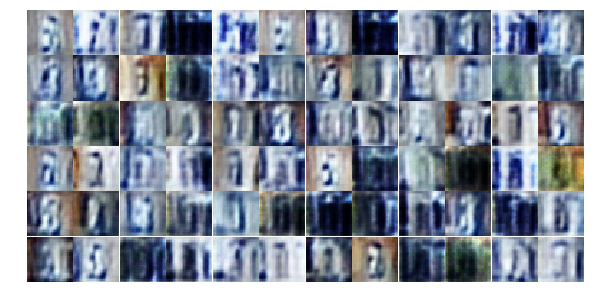

Epoch 5/25... Discriminator Loss: 1.3179... Generator Loss: 0.7879
Epoch 5/25... Discriminator Loss: 1.1648... Generator Loss: 0.7338
Epoch 5/25... Discriminator Loss: 1.1476... Generator Loss: 1.0372
Epoch 5/25... Discriminator Loss: 1.0649... Generator Loss: 0.8966
Epoch 5/25... Discriminator Loss: 0.8393... Generator Loss: 1.2484
Epoch 5/25... Discriminator Loss: 1.2573... Generator Loss: 0.7069
Epoch 5/25... Discriminator Loss: 1.2185... Generator Loss: 0.7780
Epoch 5/25... Discriminator Loss: 1.1559... Generator Loss: 0.9278
Epoch 5/25... Discriminator Loss: 1.3458... Generator Loss: 0.8736
Epoch 5/25... Discriminator Loss: 1.3311... Generator Loss: 0.7048


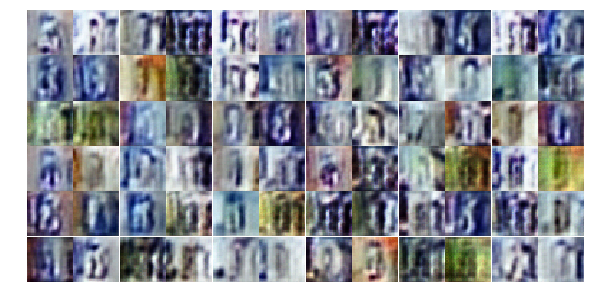

Epoch 5/25... Discriminator Loss: 1.1596... Generator Loss: 0.7995
Epoch 5/25... Discriminator Loss: 1.1648... Generator Loss: 0.9912
Epoch 5/25... Discriminator Loss: 1.0864... Generator Loss: 0.9081
Epoch 5/25... Discriminator Loss: 1.3340... Generator Loss: 0.7204
Epoch 5/25... Discriminator Loss: 1.1760... Generator Loss: 0.9307
Epoch 5/25... Discriminator Loss: 1.1664... Generator Loss: 0.9438
Epoch 5/25... Discriminator Loss: 1.1224... Generator Loss: 0.8518
Epoch 5/25... Discriminator Loss: 1.0182... Generator Loss: 1.0044
Epoch 5/25... Discriminator Loss: 1.4547... Generator Loss: 0.6144
Epoch 5/25... Discriminator Loss: 1.2636... Generator Loss: 0.8522


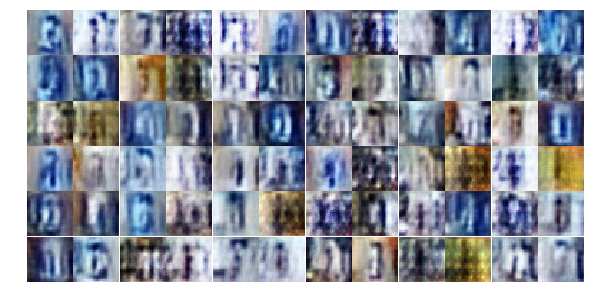

Epoch 5/25... Discriminator Loss: 1.3930... Generator Loss: 0.8524
Epoch 5/25... Discriminator Loss: 1.2754... Generator Loss: 0.7259
Epoch 5/25... Discriminator Loss: 1.2664... Generator Loss: 0.8937
Epoch 5/25... Discriminator Loss: 1.2592... Generator Loss: 0.7922
Epoch 5/25... Discriminator Loss: 1.2483... Generator Loss: 0.5889
Epoch 5/25... Discriminator Loss: 1.3309... Generator Loss: 0.7034
Epoch 5/25... Discriminator Loss: 1.4082... Generator Loss: 0.5790
Epoch 5/25... Discriminator Loss: 1.2543... Generator Loss: 0.7890
Epoch 5/25... Discriminator Loss: 1.3063... Generator Loss: 0.7678


KeyboardInterrupt: 

In [32]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

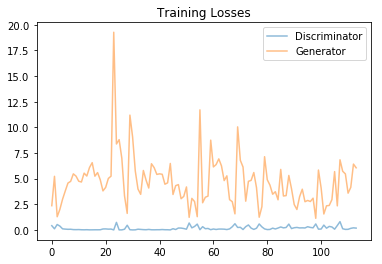

In [27]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

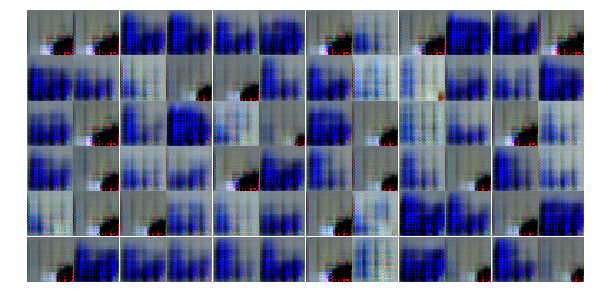

In [28]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))